# DNA-binding proteins (PCNA)

### Intro
- Download link: https://www.dropbox.com/scl/fo/793kcxhjhj7q7ye5sh51y/h?rlkey=1rrx9y0h1iuzc7suh2q15sfbq&dl=0
- In PCNA folder, you can find the structure and XTC file from my simulation. 

- There are several well known DNA-binding motif proteins.
- In those DNA-binding proteins, basic residues bind to 
- Backbone phosphates: non-specific (e.g., RNA polymerase).
- Major grooves: motif-level, specific and relatively weaker (e.g., zinc finger, helix-turn-helix etc.).
- Minor grooves: single residue-level, specific and relatively stronger (e.g., histone, exonuclease etc.).
- DNA-binding proteins diffuse along DNA to find the target sites!!!

### References
- You, S., Lee, H. G., Kim, K. & Yoo, J. Improved Parameterization of Protein-DNA Interactions for Molecular Dynamics Simulations of PCNA Diffusion on DNA. J Chem Theory Comput 16, 4006-4013 (2020). https://doi.org/10.1021/acs.jctc.0c00241
- Blainey, P. C. et al. Nonspecifically bound proteins spin while diffusing along DNA. Nat Struct Mol Biol 16, 1224-1229 (2009). https://doi.org/10.1038/nsmb.1716
- Kochaniak, A. B. et al. Proliferating cell nuclear antigen uses two distinct modes to move along DNA. J Biol Chem 284, 17700-17710 (2009). https://doi.org/10.1074/jbc.M109.008706

### Diffusion of PCNA in MD simulations
- In Kochaniak et al., you can find the single-molecule measurements of a PCNA complex as a function of time, y(t).
- Using y(t), we can calculate the mean-squared-displacement (MSD) curve.

### Questions
- Questions
    - Diffusion coefficient of the protein complex?
    - Translational vs. rotational?
- What is the physical nature of the protein-DNA contacts?
    - Visual inspection
    - Radial distribution functions?
    - What else?

### PCNA in MD simulations
- Prepare a 20-bp or 21-bp dsDNA under PBC using our web server.
    - `dna.pdb` contains the coordinates of DNA.
- PCNA is a homotrimeric ring-shaped protein complex.
- Download PDB: 5L7C or 6GIS.
- Orientation of DNA in 6GIS and our DNA from the web server are different. We want to align DNA of 6GIS parallel to the z-axis.
    - Align the principal axis of DNA to the x-axis.
    - `gmx editconf -f 6GIS.pdb -o 6GIS_orient.pdb -princ`
    - Rotate by 90 degree with respect to the y-axis.
    - `gmx editconf -f 6GIS_orient.pdb -o 6GIS_orient.pdb -rotate 0 90 0`
- Now, DNA molecules in `dna.pdb` `6GIS_orient.pdb` are parallel to the z-axis.
- Update the box information in `dna.pdb` and `6GIS_orient.pdb` using text editor.
    ```bash
    CRYST1  115.000  115.000   68.000  90.00  90.00  60.00 P 1           1
    ```
- Put `dna.pdb` and `6GIS_orient.pdb` to the center of the box we defined.
    - `gmx editconf -f dna.pdb -o dna_c.pdb -c`
    - `gmx editconf -f 6GIS_orient.pdb -o 6GIS_c.pdb -c`
- Confirm if `dna_c.pdb` and `6GIS_c.pdb` are aligned well using VMD.

- We need to convert `6GIS_c.pdb` for Gromacs using `gmx pdb2gmx`.
    - `gmx pdb2gmx  -f 6GIS_c.pdb -ignh`
    - But, `pdb2gmx` returns an error saying that some atoms are missing in `6GIS_c.pdb`.
    - This problem often occurs because crystal structure don't have all atomic coordinates in many cases.
    - There are multiple ways to fill the missing atoms: AF server (https://alphafoldserver.com), CHARMM, modeller, ..., charmm-gui.org
- We will use alphafoldserver.com to get a whole complex structure without missing atoms or residues.
    - Put protein sequence downloaded from RCSB sites in FASTA format.
    - Generate a trimer structure using AF server.
    - Load model 0 from AF to VMD.
    - Make `6GIS_c.pdb` as a top molecule in VMD.
    - VMD->Extensions->Analysis->RMSD caculator.
    - Align the AF model to `6GIS_c.pdb` using the selection "`chain A B C and name CA and resid 1 to 100`"
    - Save the aligned AF model structure to `AF.pdb` and copy `AF.pdb` to the server.

- Redo gmx pdb2gmx using AF.pdb as an input.
    - `gmx pdb2gmx -f AF.pdb -o conf.pdb -ignh`
    - `outputs`
    - `topol.top`
    - `conf.pdb`
- Put DNA information to `topol.top` and `conf.pdb`
    - In topol.top, put the following lines for DNA.
        ```bash
        ; Include DNA topologies
        #include "dna.itp"
        #include "dna.pbc.itp"
        #include "dna.hbonds.itp"
        ```
- At the end of `conf.pdb`, append `dna.pdb`.
- Modify CRYST1 line in `conf.pdb` to 
    ```bash
    CRYST1  115.000  115.000   68.000  90.00  90.00  60.00 P 1           1
    ```
- Put the PCNA structure to an infinitely long DNA from the web server.
- Then, follow a typical MD simulation protocol.
- Perform the simulation for a few microseconds.

### Analysis

- In the Dropbox folder (PCNA), you can find a trajectory file.
- Try to analysis it.

In [16]:
# Import modules
import tqdm
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from scipy.stats import linregress

**Load your trajectory**

In [6]:
# Load trajectory file
dir_path = "/home/wowjason/work/projects/md_lect/pcna"
traj = md.load(f"{dir_path}/all.fit.1ns.xtc", top=f"{dir_path}/now.pdb")
n_frames = traj.n_frames

print(traj)
print(n_frames)

<mdtraj.Trajectory with 17990 frames, 13191 atoms, 969 residues, and unitcells>
17990


**How does the pcna moves along the z-axis?**

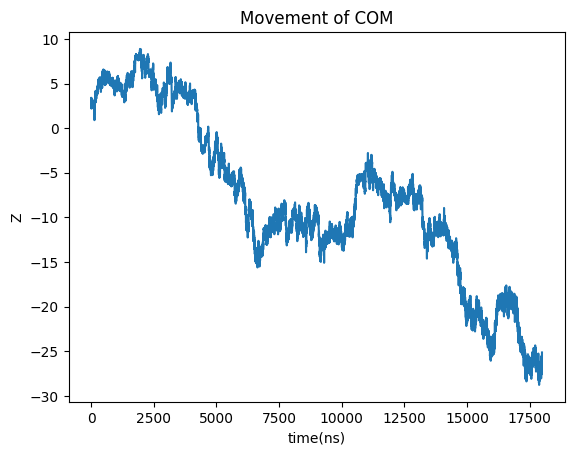

In [15]:
# Calculate the center of mass of pcna
# It may takes some time
com = md.compute_center_of_mass(traj, select="chainid 0 to 2")
plt.figure()
plt.title("Movement of COM")
plt.xlabel("time(ns)")
plt.ylabel("Z")
plt.plot(com[:, 2])
plt.show()

**Calculate MSDs of PCNA**

$MSD(t)=\frac{1}{N}\displaystyle\sum_{i=1}^{N}\frac{1}{T-t}\displaystyle\sum_{\tau=1}^{T-t}\vert r^{(i)}(\tau+T)-r^{(i)}(\tau) \vert^2$

In [7]:
msds_pcna = []

# Caculating MSD of pcna
for n_dt in range(1, n_frames):
    displacements = com[n_dt:, :] - com[:-n_dt, :]
    squared_displacements = np.sum(displacements**2, axis=-1)
    mean_squared_displacement_pcna = np.mean(squared_displacements)
    msds_pcna.append(mean_squared_displacement_pcna)

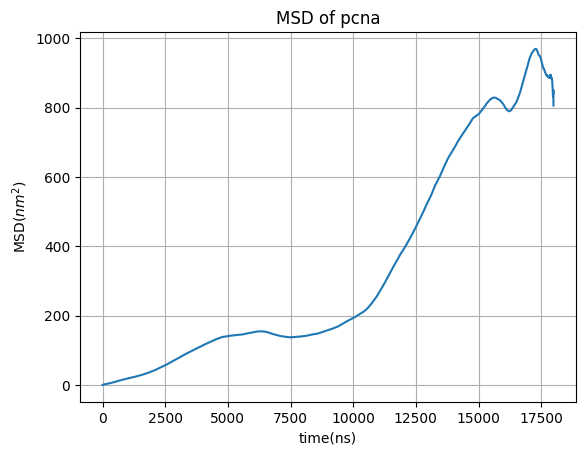

In [12]:
# Time array for 10ns
time = np.arange(1, traj.n_frames)

# Plot MSD of pcna
plt.figure()
plt.plot(time, msds_pcna)
plt.title("MSD of pcna")
plt.xlabel("time(ns)")
plt.ylabel(r"MSD($nm^2$)")
plt.grid()
plt.show()

**Calculate Diffusion coefficient**  
$2D\Delta t=MSD$

In [19]:
# Diffusion coefficient is a slope of MSD.
# Calculate diffusion coefficient of pcna
slope, _, _, _, _ = linregress(time, msds_pcna)
diffusion_coefficient_pcna = slope / 2
diffusion_coefficient_pcna

print(f"Diffusion coefficient of pcna: {diffusion_coefficient_pcna:.4f} x 10\u207B\u2079 (m\u00b2/s)")

Diffusion coefficient of pcna: 0.0269 x 10⁻⁹ (m²/s)
